**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906) by pretraining
BERT on real classification datasets. This experiment suggests that training on test set
features (no labels) is okay, which is weird and doesn't sound right. A simpler (CPU)
experiment would be to fit PCA + classifier/regressor.

**Estimated runtime**: 30 minutes on GPU. Eternity on CPU.

**Package requirements**:
```
datasets==2.9.0
matplotlib==3.4.3
pandas==1.3.4
torch==1.13.1
tqdm==4.62.3
transformers==4.26.1
```

In [ ]:
from __future__ import annotations

from datasets import load_dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, TensorDataset
from transformers import (BertTokenizer, BertForMaskedLM,
                          BertForSequenceClassification,
                          TextDataset, DataCollatorForLanguageModeling,
                          Trainer, TrainingArguments)

In [ ]:
assert torch.cuda.is_available(), 'This notebook needs to run on a GPU'

# Load dataset

In [ ]:
# DATASET_NAME = "ag_news"
# DATASET_NAME = "SetFit/amazon_counterfactual_en"
DATASET_NAME = "SetFit/enron_spam"

In [ ]:
df = pd.DataFrame(load_dataset(DATASET_NAME, split='train'))

In [ ]:
len(df)

31716

We'll only need 50 + 500 + 500 = 1.05k observations

In [ ]:
df.head()

,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


Ensure your dataframe passes these checks

In [ ]:
assert len(set(df.index)) == len(df)

In [ ]:
assert 'text' in df.columns
assert 'label' in df.columns
# please assign a new column if the test fails

In [ ]:
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)

In [ ]:
df['label'].value_counts(normalize=True)

1    0.509617
0    0.490383
Name: label, dtype: float64

# Download model

In [ ]:
_ = BertForMaskedLM.from_pretrained('bert-base-uncased')
# just downloading it to your comp if it hasn't already been downloaded

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# MLM

In [ ]:
class TokenizedSentencesDataset(Dataset):
    '''
    taken from https://github.com/UKPLab/sentence-transformers/blob/master/examples/unsupervised_learning/MLM/train_mlm.py
    '''
    def __init__(self, sentences, tokenizer, max_length,
                 cache_tokenization=False):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.max_length = max_length
        self.cache_tokenization = cache_tokenization

    def __getitem__(self, item):
        if not self.cache_tokenization:
            return self.tokenizer(self.sentences[item],
                                  add_special_tokens=True,
                                  truncation=True, max_length=self.max_length,
                                  return_special_tokens_mask=True)

        if isinstance(self.sentences[item], str):
            self.sentences[item] = self.tokenizer(self.sentences[item],
                                                  add_special_tokens=True,
                                                  truncation=True,
                                                  max_length=self.max_length,
                                                  return_special_tokens_mask=True)
        return self.sentences[item]

    def __len__(self):
        return len(self.sentences)

In [ ]:
def bert_pretrain(texts: list[str], output_dir: str ='./pretrained_bert'):
    '''
    Saves a BERT model which was pretrained on `texts` to `output_dir` using
    masked language modeling loss.

    It can be loaded for other tasks using, for example::

        from transformers import BertForSequenceClassification
        model = BertForSequenceClassification.from_pretrained(output_dir)
    '''
    # Set up data
    train_dataset = TokenizedSentencesDataset(texts, tokenizer, max_length=100)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                    mlm=True,
                                                    mlm_probability=0.15)

    # Set up Trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=32,
        save_strategy='no',
        optim="adamw_torch",
        prediction_loss_only=True,
    )

    # Trainer will modify this model, so need to re-load a fresh one every time
    # this function is called
    trainer = Trainer(
        model=BertForMaskedLM.from_pretrained('bert-base-uncased').to('cuda'),
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer.train()
    trainer.save_model()

# Classification

In [ ]:
class TextClassificationDataset(torch.utils.data.Dataset):
    '''
    taken from https://huggingface.co/transformers/v3.2.0/custom_datasets.html#sequence-classification-with-imdb-reviews
    '''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def _classification_dataset(texts: list[str], labels: list[int]) -> TextClassificationDataset:
    encodings = tokenizer(texts, return_tensors='pt', truncation=True,
                          padding=True)
    labels = torch.tensor(labels)
    return TextClassificationDataset(encodings, labels)

In [ ]:
def bert_finetune_classification(texts: list[str],
                                 labels: list[int],
                                 num_labels: int,
                                 pretrained_model_name_or_path: str = './pretrained_bert') -> Trainer:
    '''
    Returns a BERT model `Trainer` which was finetuned on classification data
    `texts, labels`. 
    '''
    train_dataset = _classification_dataset(texts, labels)
    classifier_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        optim="adamw_torch",
    )
    classifier_trainer = Trainer(
        model=(BertForSequenceClassification
               .from_pretrained(pretrained_model_name_or_path,
                                num_labels=num_labels)
               .to('cuda')),
        args=classifier_args,
        train_dataset=train_dataset,
    )
    classifier_trainer.train()
    return classifier_trainer

In [ ]:
def classifier_accuracy(texts: list[str],
                        labels: list[int],
                        trained_classifier: Trainer) -> float:
    '''
    Returns the accuracy of `trained_classifier` on `texts` by comparing its
    predictions to `labels`.
    '''
    eval_dataset = _classification_dataset(texts, labels)
    pred_out = trained_classifier.predict(eval_dataset)
    preds = pred_out.predictions.argmax(axis=1)
    return (preds == labels).mean()

# Experiment

In [ ]:
def _stratified_sample(df: pd.DataFrame, sample_size: int,
                       random_state: int=None) -> pd.DataFrame:
    # let's not worry about not exactly returning a df w/ size sample_size for
    # now. it's nbd for this experiment
    num_labels = len(set(df['label']))
    num_obs_per_label = int(sample_size / num_labels)

    def label_sampler(df_label: pd.DataFrame) -> pd.DataFrame:
        return df_label.sample(num_obs_per_label, random_state=random_state)

    return df.groupby('label', group_keys=False).apply(label_sampler)


def _split(df: pd.DataFrame, num_train: int=50, num_test: int=2000,
           random_state: int=None, stratified_train: bool=True
           ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Returns 3 (non-overlapping) dataframes which are randomly subsampled from
    `df`. The first has `num_train` rows, and the last two have `num_test` rows
    each.
    '''
    if stratified_train:
        df_train = _stratified_sample(df, num_train, random_state=random_state)
    else:
        df_train = df.sample(num_train, random_state=random_state)

    random_state = None if random_state is None else random_state+1
    df_extra, df_test = train_test_split(df.drop(df_train.index),
                                         train_size=num_test,
                                         test_size=num_test,
                                         random_state=random_state)
    return df_train, df_extra, df_test

In [ ]:
def experiment_loop(df: pd.DataFrame, num_train: int=50, num_test: int=500,
                    stratified_train: bool=True, random_state: int=None):
    num_labels = len(set(df['label']))
    df_train, df_extra, df_test = _split(df, num_train=num_train,
                                         num_test=num_test,
                                         stratified_train=stratified_train,
                                         random_state=random_state)

    print('Pretraining on extra')
    bert_pretrain(df_extra['text'].tolist())  # overwrites ./pretrained_bert/
    print('Training bert-base-uncased on train')
    trained_classifier = bert_finetune_classification(df_train['text'].tolist(),
                                                      df_train['label'].tolist(),
                                                      num_labels=num_labels)
    print('Testing on test')
    extra_accuracy = classifier_accuracy(df_test['text'].tolist(),
                                         df_test['label'].tolist(),
                                         trained_classifier)

    print('Pretraining on test')
    bert_pretrain(df_test['text'].tolist())  # overwrites ./pretrained_bert/
    print('Training on train')
    trained_classifier = bert_finetune_classification(df_train['text'].tolist(),
                                                      df_train['label'].tolist(),
                                                      num_labels=num_labels)
    print('Testing on test')
    test_accuracy = classifier_accuracy(df_test['text'].tolist(),
                                        df_test['label'].tolist(),
                                        trained_classifier)

    return extra_accuracy, test_accuracy  # paired data

In [ ]:
num_trials = 20
extra_accuracies = []
test_accuracies = []

for i in range(num_trials):
    clear_output(wait=True)
    print(f'Running trial {i+1}\n')
    extra_accuracy, test_accuracy = experiment_loop(df, random_state=42+i)
    extra_accuracies.append(extra_accuracy)
    test_accuracies.append(test_accuracy)

Running trial 20

Pretraining on extra


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss


Training bert-base-uncased on train


Some weights of the model checkpoint at ./pretrained_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pretrained_bert and are n

Step,Training Loss


Testing on test


Pretraining on test


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss


Training on train


Some weights of the model checkpoint at ./pretrained_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pretrained_bert and are n

Step,Training Loss


Testing on test


In [ ]:
extra_accuracies

[0.85,
 0.644,
 0.76,
 0.662,
 0.582,
 0.69,
 0.762,
 0.78,
 0.778,
 0.572,
 0.556,
 0.726,
 0.73,
 0.646,
 0.728,
 0.724,
 0.81,
 0.84,
 0.768,
 0.794]

In [ ]:
test_accuracies

[0.834,
 0.676,
 0.642,
 0.676,
 0.536,
 0.598,
 0.808,
 0.688,
 0.828,
 0.7,
 0.564,
 0.704,
 0.732,
 0.64,
 0.76,
 0.616,
 0.812,
 0.82,
 0.734,
 0.852]

In [ ]:
extra_accuracies = np.array(extra_accuracies)
test_accuracies = np.array(test_accuracies)

In [ ]:
dataset = DATASET_NAME.split('/')[-1]

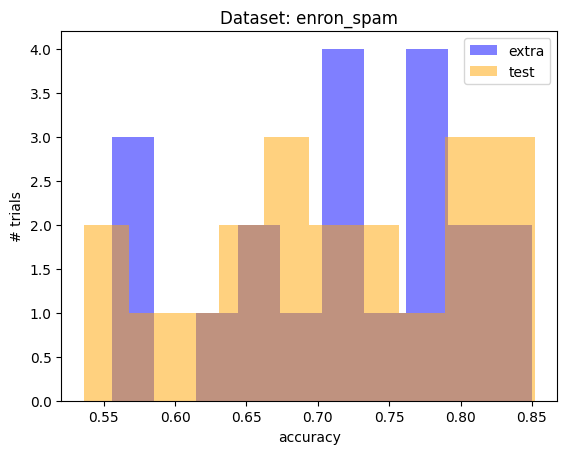

In [ ]:
plt.hist(extra_accuracies, label='extra', color='blue',   alpha=0.5)
plt.hist(test_accuracies,  label='test',  color='orange', alpha=0.5)
plt.xlabel('accuracy')
plt.ylabel('# trials')
plt.title(f'Dataset: {dataset}')
plt.legend();

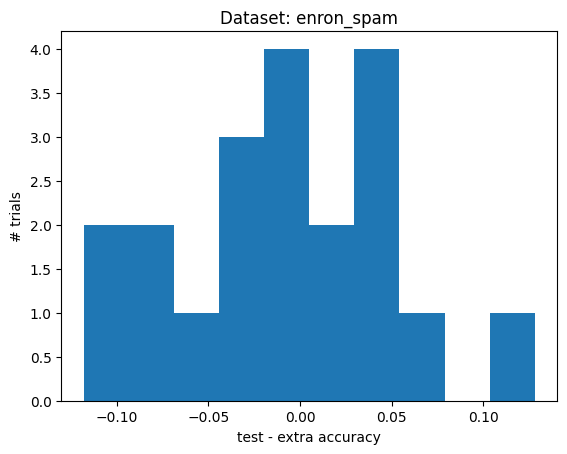

In [ ]:
plt.hist(test_accuracies - extra_accuracies)
plt.xlabel('test - extra accuracy')
plt.ylabel('# trials')
plt.title(f'Dataset: {dataset}');

In [ ]:
(test_accuracies - extra_accuracies).mean()

-0.009100000000000007